# GBIF_Request

In [13]:
!pip install pygbif --quiet
!pip install geopandas --quiet


ERROR: Could not find a version that satisfies the requirement StringIO (from versions: none)
ERROR: No matching distribution found for StringIO
     |████████████████████████████████| 972kB 4.7MB/s 
     |████████████████████████████████| 10.9MB 13.1MB/s 
     |████████████████████████████████| 14.7MB 251kB/s 


## Fazendo uma aquisição completa para uma espécie

In [7]:
import requests
payload = {'taxonKey': '3873513','publishingCountry':'BR','limit':300,'hasCoordinate':True,'year':'2000,2020'} # sem hasCoordinate vem 900 e com vem 400
r = requests.get("http://api.gbif.org/v1/occurrence/search", params=payload)
#r = requests.get('http://api.gbif.org/v1/occurrence/search?taxonKey=3873513')
print("Response status: ",r)

Response status:  <Response [200]>


In [8]:
reponse = r.json()
reponse

{'count': 315,
 'endOfRecords': False,
 'facets': [],
 'limit': 300,
 'offset': 0,
 'results': [{'acceptedScientificName': 'Cynophalla hastata J.Presl',
   'acceptedTaxonKey': 3873513,
   'basisOfRecord': 'PRESERVED_SPECIMEN',
   'catalogNumber': '22903',
   'class': 'Magnoliopsida',
   'classKey': 220,
   'collectionCode': 'HST',
   'country': 'Brazil',
   'countryCode': 'BR',
   'crawlId': 222,
   'datasetKey': 'b3769e61-c3d0-4046-81cf-bf4d6b23b444',
   'datasetName': 'HST - Herbário Sérgio Tavares',
   'day': 9,
   'decimalLatitude': -6.08,
   'decimalLongitude': -35.8575,
   'elevation': 218.0,
   'elevationAccuracy': 0.0,
   'eventDate': '2019-03-09T00:00:00',
   'extensions': {},
   'facts': [],
   'family': 'Capparaceae',
   'familyKey': 3111,
   'gbifID': '2452748819',
   'genericName': 'Cynophalla',
   'genus': 'Cynophalla',
   'genusKey': 6370797,
   'geodeticDatum': 'WGS84',
   'identifiedByIDs': [],
   'identifier': 'BRA:UFRPE:HST:22903',
   'identifiers': [],
   'installat

In [6]:
reponse['results'][1]

{'acceptedScientificName': 'Cynophalla hastata J.Presl',
 'acceptedTaxonKey': 3873513,
 'basisOfRecord': 'PRESERVED_SPECIMEN',
 'catalogNumber': '132322',
 'class': 'Magnoliopsida',
 'classKey': 220,
 'collectionCode': 'ALCB',
 'continent': 'SOUTH_AMERICA',
 'country': 'Brazil',
 'countryCode': 'BR',
 'crawlId': 210,
 'datasetKey': '5b5cf455-a448-4c0a-aecd-3e0956f27f10',
 'datasetName': 'ALCB - Herbário Alexandre Leal Costa',
 'dateIdentified': '2018-06-01T00:00:00',
 'day': 20,
 'decimalLatitude': -9.45,
 'decimalLongitude': -41.883333,
 'eventDate': '2018-01-20T00:00:00',
 'extensions': {},
 'facts': [],
 'family': 'Capparaceae',
 'familyKey': 3111,
 'gbifID': '1889188943',
 'genericName': 'Cynophalla',
 'genus': 'Cynophalla',
 'genusKey': 6370797,
 'geodeticDatum': 'WGS84',
 'identifiedBy': 'Guedes, ML',
 'identifiedByIDs': [],
 'identifier': 'BRA:UFBA:ALCB:132322',
 'identifiers': [],
 'installationKey': 'b38ff2b7-c8af-454e-b5af-ee760f0d5bca',
 'institutionCode': 'Universidade Fede

## Classe Genérica para fazer a requisição

In [52]:
import requests
import pandas as pd
import geopandas


class GBIF_REQUESTER:
  def __init__(self, limit:int =300, hasCoordinate: bool=True  ,lowYear=None,upYear=None):
    self.limit = limit
    self.hasCoordinate = hasCoordinate
    self.lowYear = lowYear
    self.upYear = upYear
    assert (lowYear and upYear),"You must provide lowYear and upYear" 
    self.year_range = str(lowYear) + ',' +str(upYear)

  def get_specie_json_request(self, taxonKey:int):
    payload = {'taxonKey': str(taxonKey) ,'limit':self.limit,'hasCoordinate':self.hasCoordinate,'year':self.year_range} 
    r = requests.get("http://api.gbif.org/v1/occurrence/search", params=payload)
    r = r.json()
    print(str(r['count']) + ' occurrences were found. The limit of occurrences per request is ' + str(self.limit))
    return r

  def refact_dict(self, result):
    columns = result.keys()
    desired_columns = ['scientificName','decimalLongitude','decimalLatitude','country','stateProvince','eventDate','day','month','year','occurrenceRemarks']
    for d_col in desired_columns:
      if d_col not in columns:
        result[d_col] = None
    
    return result
  def get_specie_dataframe(self, taxonKey:int):
    df = pd.DataFrame(columns=['SCIENTIFIC_NAME','LONGITUDE','LATITUDE','COUNTRY','STATE_PROVINCE','IDENTIFICATION_DATE','DAY','MONTH','YEAR','OCCURENCE_REMARKS'])
    reponse = self.get_specie_json_request(taxonKey)
    for result in reponse['results']:
      result = self.refact_dict(result)
      df = df.append({
          "SCIENTIFIC_NAME": result['scientificName'],
          "LONGITUDE": result['decimalLongitude'],
          "LATITUDE":  result['decimalLatitude'],
          "COUNTRY":  result['country'],
          "STATE_PROVINCE":  result['stateProvince'],
          "IDENTIFICATION_DATE":  result['eventDate'],
          "DAY":  result['day'],
          "MONTH":  result['month'],
          "YEAR":  result['year'],
          "OCCURENCE_REMARKS":  result['occurrenceRemarks']
          }, ignore_index=True)
    return df

  def get_specie_geo_dataframe(self, taxonKey:int):
    df = self.get_specie_dataframe(taxonKey)
    gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.LONGITUDE, df.LATITUDE))
    return gdf


criando instancia

In [53]:
gbif_requester = GBIF_REQUESTER(limit=300, hasCoordinate=True  ,lowYear=2000,upYear=2020)

recuperandos dados

In [56]:
gdf = gbif_requester.get_specie_geo_dataframe(3873513)
gdf.head()

343 occurrences were found. The limit of occurrences per request is 300


,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,OCCURENCE_REMARKS,geometry
0,Cynophalla hastata J.Presl,-35.857500,-6.080000,Brazil,Rio Grande do Norte,2019-03-09T00:00:00,9,3,2019,Arbusto; folhas verde-escuras; frutos imaturos...,POINT (-35.85750 -6.08000)
1,Cynophalla hastata J.Presl,-41.883333,-9.450000,Brazil,Bahia,2018-01-20T00:00:00,20,1,2018,"escandente. Folhas cartáceas, discolores. Infl...",POINT (-41.88333 -9.45000)
2,Cynophalla hastata J.Presl,-43.019722,-10.979722,Brazil,Bahia,2018-01-23T00:00:00,23,1,2018,"Liana/cipó; 4 metros . Fruto imaturo; 1,5X8,0 ...",POINT (-43.01972 -10.97972)
3,Cynophalla hastata J.Presl,-35.660556,-6.210000,Brazil,Rio Grande do Norte,2018-02-02T00:00:00,2,2,2018,"Ca de 1,5 m de alt. Folhas verde-claras. Botõe...",POINT (-35.66056 -6.21000)
4,Cynophalla hastata J.Presl,-62.616181,17.190144,Saint Kitts and Nevis,Saint Thomas Lowland,2018-04-19T11:12:34,19,4,2018,None,POINT (-62.61618 17.19014)


## Printing data

In [60]:
import matplotlib.pyplot as plt
def plot_location_map(gdf,specie_color='red'):
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

  # We restrict to South America.
  ax = world[world.continent == 'South America'].plot(
      color='white', edgecolor='black')

  # We can now plot our ``GeoDataFrame``.
  gdf.plot(ax=ax, color=specie_color)

  plt.show()

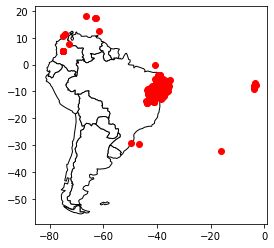

In [61]:
plot_location_map(gdf)